# Motor Characterization: Pololu

2018 March 3
Jean-Christophe Perrin

This jupyter notebook adapts motor characterization code from the ME112 crawler project to characterize our new motor for the final project. Jan Sokol carried out the empirical testing of the motor on March 3.

Specifically, we are looking at a [Tamiya 72005 6-Speed Gearbox Kit](https://www.pololu.com/product/74/specs).

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Useful Constants

These are some simple conversions and constants that will be useful later in our calculations.

In [3]:
m_to_in = 39.37                     # Meters to inches
N_to_lbf = 0.2248                   # Newtons to pounds force
Nm_to_inlbf = N_to_lbf*m_to_in      # Nm to inchpounds torque
inprsec_ftprmin = 60.0/12           # inches/second to feet/minute
rpm_to_radps = 2*np.pi/60           # rotations/minute to radians/second
deg_to_rad = np.pi/180              # degrees to radians
watt_to_hp = 745.7                  # Watts to horsepower

## Importing Lab Data

Jan Sokol collected data from our motor concerning different current-voltage pairs at stall (when the motor axel is helld fixed) and at no load (freely spinning). From these measurements we can characterize the expected output of the motor. They reside in an excel document that should not be altered

In [4]:
xls = pd.ExcelFile('motorPololu_Data.xlsx')
nl = pd.read_excel(xls, "noLoad")
stall = pd.read_excel(xls, "stall")

## Motor Constant Calculations

### Finding R
At $\omega = 0$ we know that $V = iR$. Therefore, R of the motor is equal to V/i_stall

In [5]:
stall['R'] = stall['V'] / stall['I']
R = np.mean(stall['R']) # [Ohm]

### Finding K (Motor Constant)

At $\tau _l = 0$ we know that the motor equation becomes:
\begin{equation}
    V - i_{nl}R - k \omega_{nl} = 0
\end{equation}

Rearranging, we find
\begin{equation}
    k = \frac{V-i_{nl}R}{\omega _{nl}}
\end{equation}

In [6]:
nl['w'] = nl['RPM'] / 60 * 2 * np.pi      # [rad/s] converting to rad/s
nl['k'] = (nl['V'] - nl['I'] * R)/nl['w']

Now that we have value for an estimated k at each collected data point, let's find the linear regression of the data and use the slope (or average k) as an estimator of the actual K value.

0.0021645623179572596


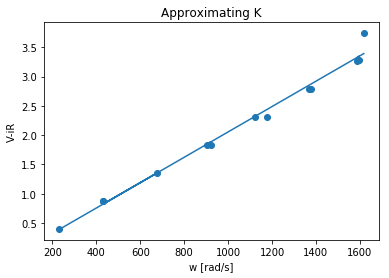

In [7]:
K, intercept = np.polyfit(nl['w'], nl['w']*nl['k'], 1)

kChecking = plt.figure()
ax1 = kChecking.add_subplot(111)
ax1.scatter(nl['w'], nl['V'] - nl['I'] * R)
ax1.plot(nl['w'], K*nl['w']+intercept)
ax1.set(xlabel='w [rad/s]', ylabel='V-iR', title='Approximating K')

print K

## Finding $\tau_l$

At no load, the motor is spinning freely, $T_L = 0$, and the only torque is the friction torque, $T_f$.

\begin{equation}
k i_{nl} = T_f 
\end{equation}

In [8]:
nl['Tf'] = nl['k']*nl['I'] 
Tf = np.mean(nl['Tf'])  # [Nm] Frictional Torque of the motor
print Tf

0.00045494957087


# Determining Power, Efficiency and Torque

The power output by the motor will vary over operating range of the motor (in amps). We plan on operating our motor at 6 V DC and somewhere between the stall and no-load current.

In [15]:
operatingVoltage = 3 # [V]
iMin = stall['I'][operatingVoltage] # [A]
iMax = nl['I'][operatingVoltage] # [A]

iRange = np.linspace(iMin, iMax)

In [18]:
torqueLoad = K*iRange - Tf
angularVelocity = (operatingVoltage - iRange*R)/K
powerOut = torqueLoad * angularVelocity
powerIn = iRange * operatingVoltage
efficiency = powerOut/powerIn

Here we plot a number of the different curves over the operating range. We'll combine the three curves into a single figure as they are frequently referenced together.

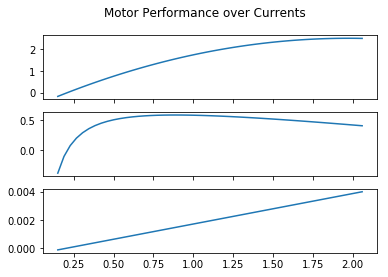

In [19]:
fig, (powerCurve, efficiencyCurve, torqueCurve) = plt.subplots(nrows=3, ncols=1, sharex=True)
fig.suptitle('Motor Performance over Currents')

powerCurve.plot(iRange, powerOut)
efficiencyCurve.plot(iRange, efficiency)
torqueCurve.plot(iRange, torqueLoad)